In [1]:
# Графики и вычисления к лекции 4 ("Модель локальной волатильности")
# Здесь строится график, показывающий неверное движение улыбки волатильности
# в модели локальной волатильности

%load_ext autoreload
%autoreload 2
from dataclasses import dataclass, replace
from math import *
import cmath
import numpy as np
import scipy.stats as st
from scipy.integrate import quad
from scipy.optimize import newton
from scipy.interpolate import LinearNDInterpolator
import matplotlib as mpl
import matplotlib.pyplot as plt
from locvol import AndreasenHuge

plt.rcParams.update({
    "font.size": 11,
    "axes.titlesize": 8,
    "axes.labelsize": 8,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,
    "legend.fontsize": 7,
    "figure.titlesize": 8,
    "figure.dpi": 600,
    "lines.linewidth": 1,
    "axes.linewidth": 0.6,
    "grid.linewidth": 0.3,
    "xtick.major.width": 0.6,
    "ytick.major.width": 0.6,
    "xtick.minor.width": 0.3,
    "ytick.minor.width": 0.3,
})

In [2]:
# Вспомогательные функции

# Численное дифференцирование (удалили из SciPy)
def derivative(f, x0, dx, n):
    if n == 1:
        return (f(x0 + dx) - f(x0 - dx)) / (2 * dx)
    elif n == 2:
        return (f(x0 + dx) - 2 * f(x0) + f(x0 - dx)) / (dx**2)
    else:
        return nan


# Подразумеваемая волатильность опциона колл, с нулевой безрисковой ставкой
def implied_vol(s, T, K, C):
    x = np.log(s/K)
    p = C/np.sqrt(s*K)

    sigma0 = np.where(np.isclose(x, 0), -2*st.norm.ppf((1-p)/2), np.sqrt(2*np.abs(x)))

    def f(sigma):
        return np.exp(x/2)*st.norm.cdf(x/sigma+sigma/2) - np.exp(-x/2)*st.norm.cdf(x/sigma-sigma/2) - p

    res = newton(func=f, x0=sigma0, full_output=True, disp=False)

    if np.isscalar(K):
        return res[0]/sqrt(T) if res[1].converged else np.nan
    else:
        return np.where(res.converged, res.root/sqrt(T), np.nan)


# Функции для модели Хестона

# Характеристическая функция
def _heston_cf(u, T, V0, kappa, theta, sigma, rho):
    d = cmath.sqrt((1j*rho*sigma*u - kappa)**2 + sigma**2*(1j*u + u**2))
    g = ((1j*rho*sigma*u - kappa + d) / (1j*rho*sigma*u - kappa - d))
    C = (kappa*theta/sigma**2 * (
        (kappa - 1j*rho*sigma*u - d)*T - 2*cmath.log((1 - g*cmath.exp(-d*T))/(1-g))))
    D = ((kappa - 1j*rho*sigma*u - d)/sigma**2 * ((1-cmath.exp(-d*T)) / (1-g*cmath.exp(-d*T))))
    return cmath.exp(C + D*V0)


# Подынтегральная функция для вычисления цены опциона
def _heston_price_integrand(u, t, omega, v0, kappa, theta, sigma, rho):
    return (cmath.exp(1j*omega*u)/(1j*u) *
            (_heston_cf(u-1j, t, v0, kappa, theta, sigma, rho) -
                exp(-omega)*_heston_cf(u, t, v0, kappa, theta, sigma, rho))).real


# Подынтегральная функция для вычисления функции распределения
def _heston_cdf_integrand(u, t, omega, v0, kappa, theta, sigma, rho):   
    return (cmath.exp(1j*omega*u)/(1j*u) * _heston_cf(u, t, v0, kappa, theta, sigma, rho)).real


@dataclass
class Heston:
    s0: float
    v0: float
    kappa: float
    theta: float
    sigma: float
    rho: float

    def call_price(self, T, K):
        if np.isscalar(K):
            return self._call_price(T, K)
        else:
            return np.array([self._call_price(T, k) for k in K])

    def _call_price(self, t, k):
        return self.s0 * (
            (1 - k/self.s0)/2 +
            1/pi * quad(_heston_price_integrand,
                0, inf,
                args=(t, log(self.s0/k), self.v0, self.kappa, self.theta, self.sigma, self.rho))[0]
            )

    def implied_vol(self, T, K):
        return implied_vol(self.s0, T, K, self.call_price(T, K))
    
    def local_vol(self, t, s, ds=0.01, dt=1/250):
        return np.sqrt(2*derivative(
            lambda u: self.call_price(u, s), t, dt, n=1)
            / (s*s*derivative(lambda y: self.call_price(t, y), s, s*ds, n=2)))
    
    def cdf(self, t, s):
        if np.isscalar(s):  
            return 0.5 - 1/pi * quad(_heston_cdf_integrand, 0, inf,
                    args=(t, log(self.s0/s), self.v0, self.kappa, self.theta, self.sigma, self.rho))[0]
        else:
            return np.array([self.cdf(t, s_) for s_ in s])
    
    def quantile(self, t, p):
        return newton(lambda s: self.cdf(t, s) - p, np.full_like(p, self.s0))
    

@dataclass
class LocalVol:
    s0: float
    sigma: callable

    def simulate(self, t, steps, paths):
        dt = t/steps
        X = np.full(paths, log(self.s0))

        for i in range(steps):
            sigma = self.sigma(i*dt, np.exp(X))
            X += -0.5*sigma**2*dt + sigma*np.random.randn(paths)*sqrt(dt)

        return np.exp(X)
    
    def call_price(self, T, K, steps, paths):
        S = self.simulate(T, steps, paths)
        return np.mean(np.maximum(np.subtract.outer(S, K), 0), axis=0)
    
    def implied_vol(self, T, K, steps, paths):
        return implied_vol(self.s0, T, K, self.call_price(T, K, steps, paths))


In [3]:
# Параметры модели Хестона в примере
heston = Heston(100, 0.1, 1, 0.1, 2, -0.6)

# Сетка по времени для вычисления локальной волатильности
# (по пространству берется сетка от 0.5% до 99.5% квантили с шагом 3%
T = np.linspace(0, 0.25, 26)

# Массивы точек и значений локальной волатильности, по которым будем интерполировать
points = [(0, heston.s0)]
values = [float(heston.local_vol(T[1]/2, heston.s0))]

for t in T[1:]:
    K = heston.quantile(t, np.linspace(0.005, 0.995, 34))
    points = points + [(t, k) for k in K]
    values = values + list(heston.local_vol(t, K))

# Модель локальной волатильности
sigma = LinearNDInterpolator(points, values, fill_value = 0)
lv = LocalVol(heston.s0, sigma)

In [4]:
# Вычисление улыбок волатильности
K = np.linspace(80, 120, 100)
t = T[-1]
initial_iv = heston.implied_vol(t, K)
new_heston_iv = replace(heston,  s0=heston.s0*1.05).implied_vol(t, K)
new_lv_iv = replace(lv, s0=heston.s0*1.05).implied_vol(t, K, 100, 100000)

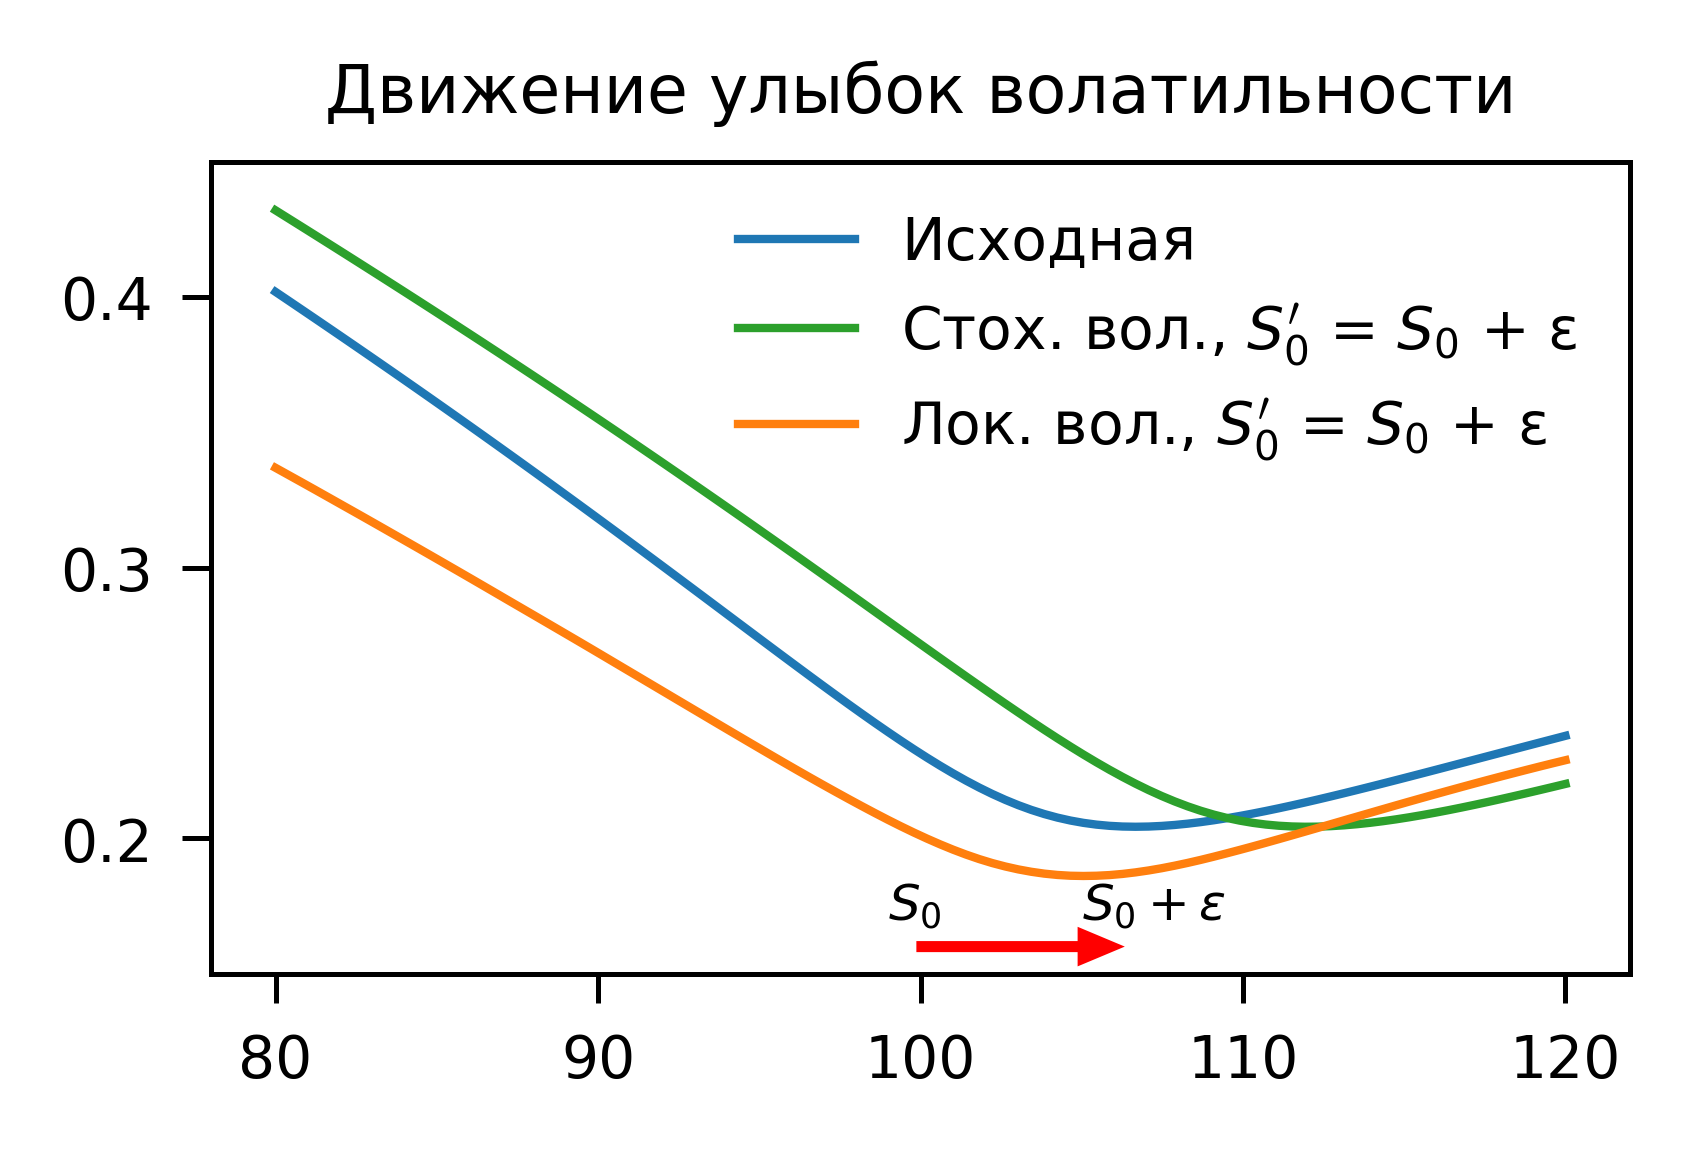

In [5]:
# Графики
fig, ax = plt.subplots(1, 1, figsize=(2.7, 1.8), constrained_layout=True)
ax.set_title('Движение улыбок волатильности')
ax.set_ylim(0.15, 0.45)
ax.plot(K, initial_iv, label='Исходная')
ax.plot(K, new_heston_iv, label="Стох. вол., $S_0'$ = $S_0$ + ε", color='C2')
ax.plot(K, new_lv_iv, label="Лок. вол., $S_0'$ = $S_0$ + ε", color='C1')

ax.arrow(100, 0.16, 5, 0, color='r', head_width=0.01, head_length=1)
ax.annotate('$S_0$', (99, 0.17), fontsize=6)
ax.annotate('$S_0+\\epsilon$', (105, 0.17), fontsize=6)

plt.legend(frameon=False);

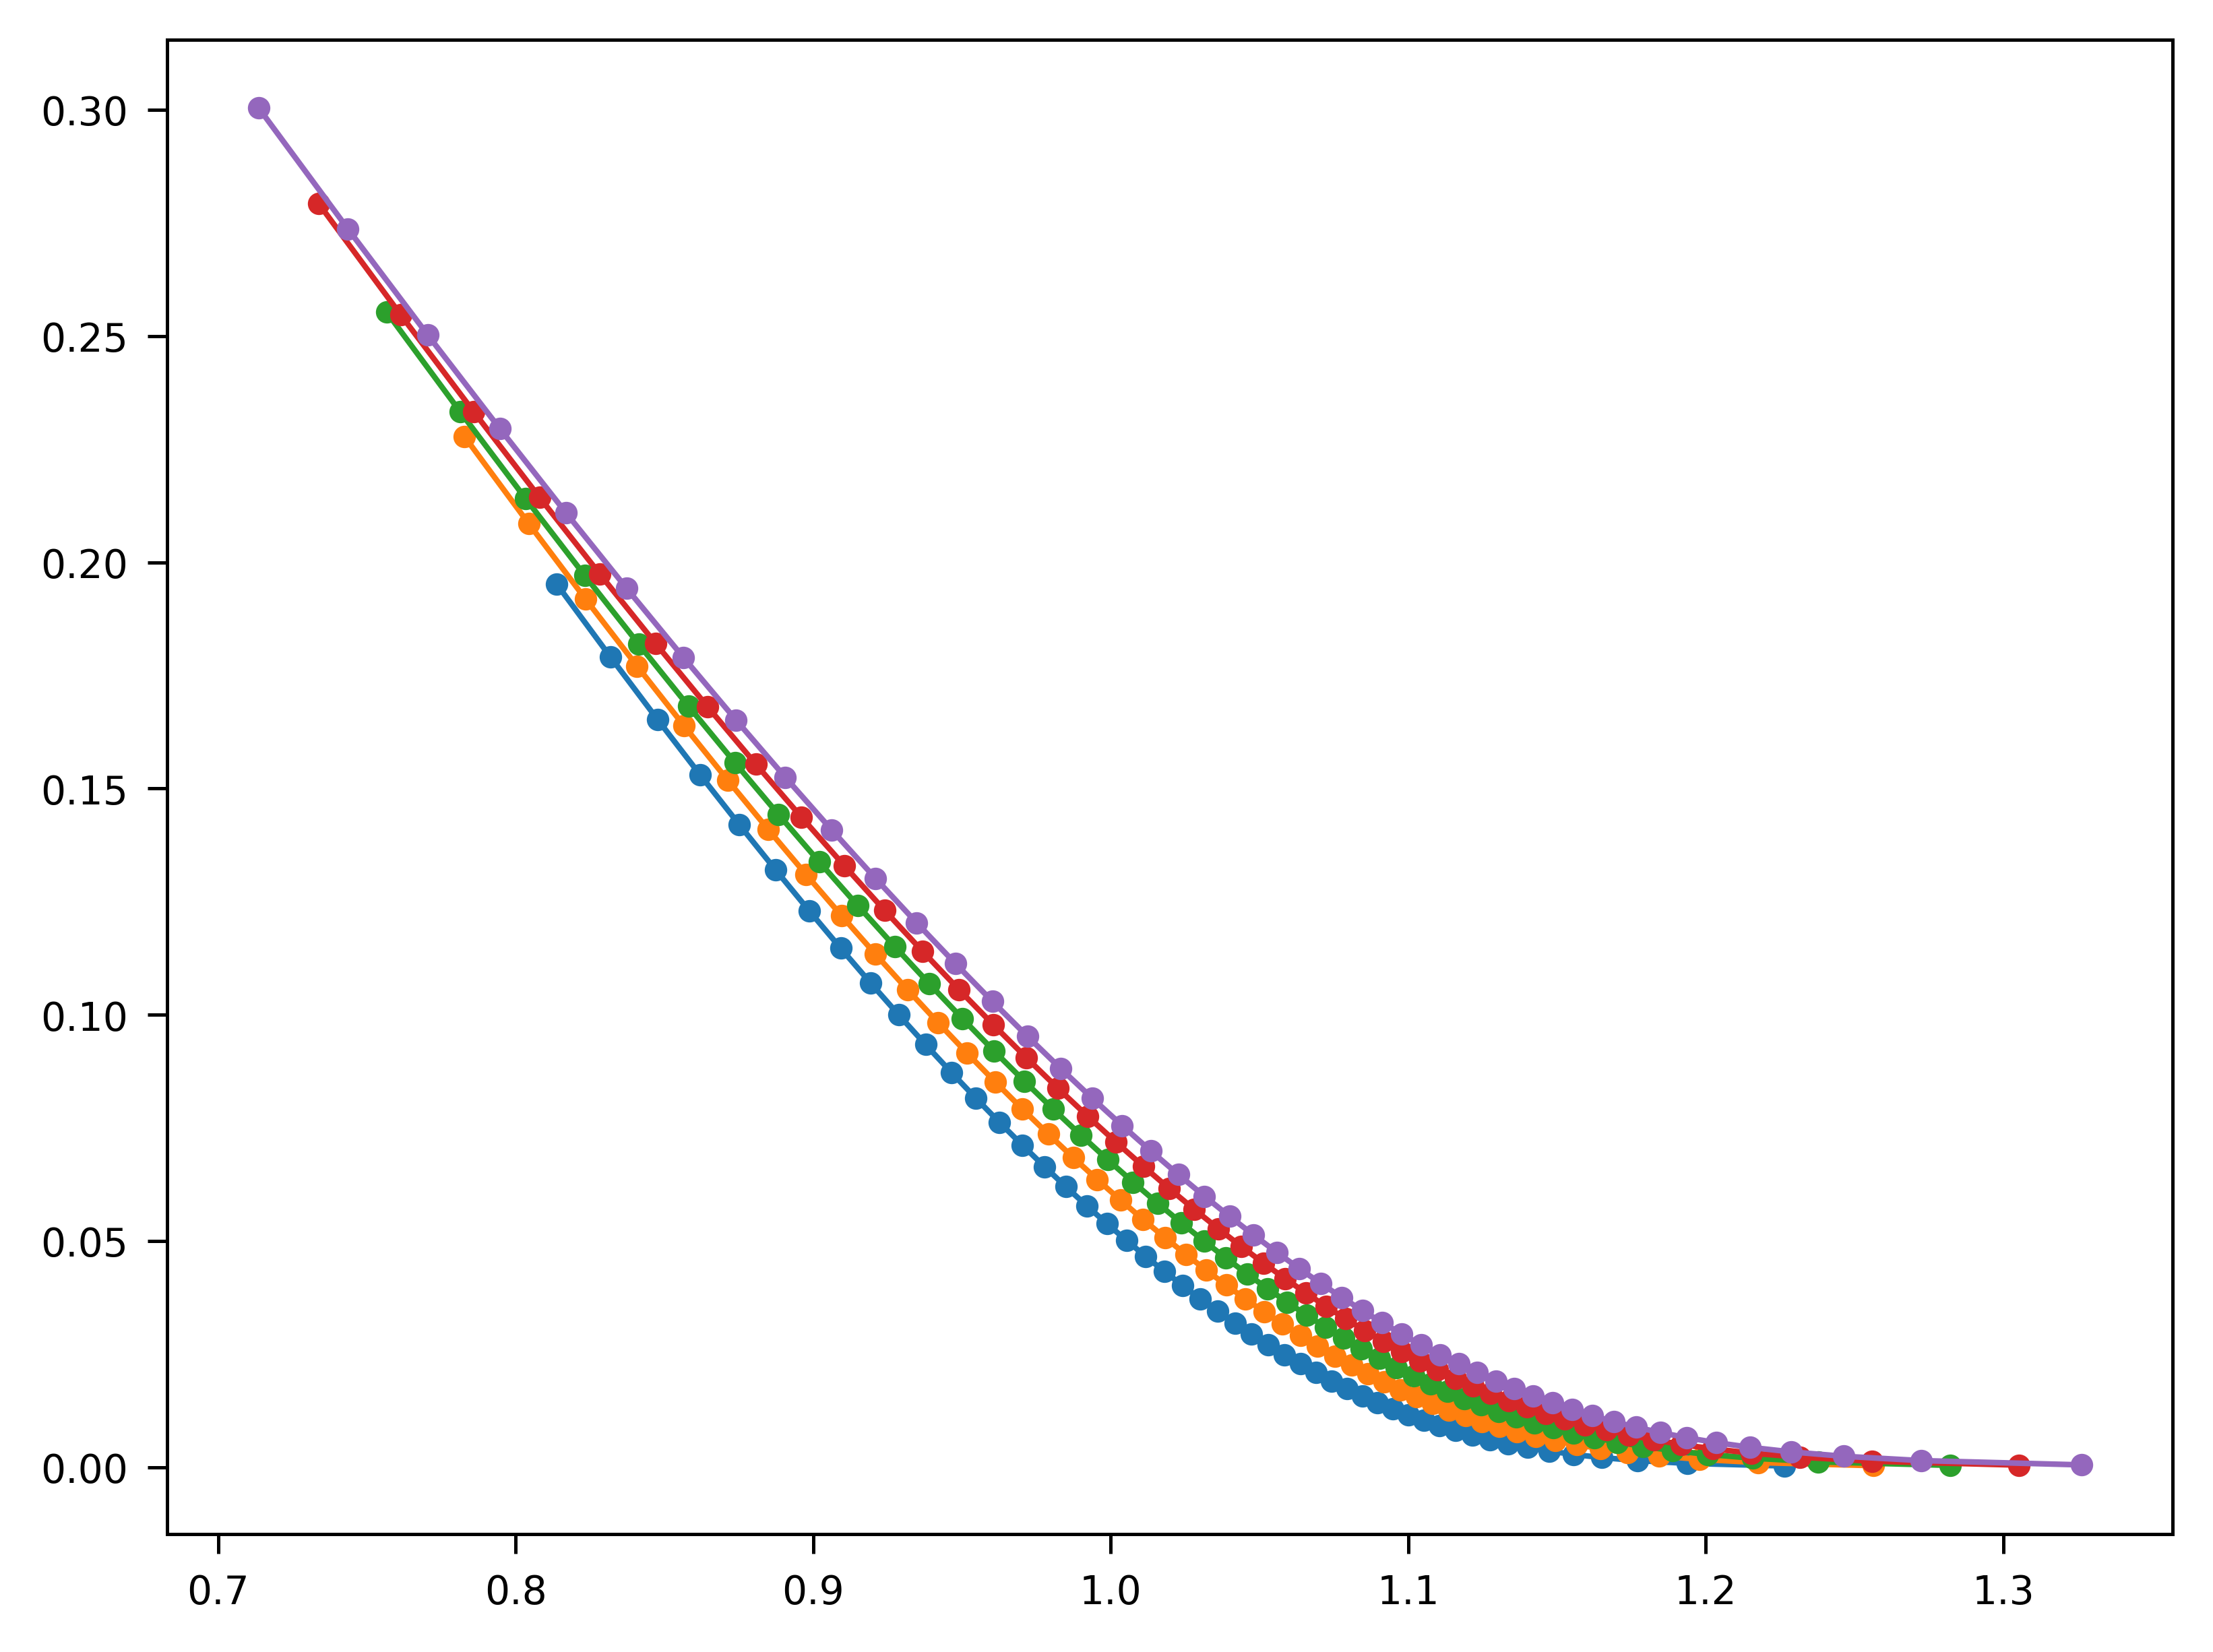

In [6]:
heston = Heston(1, 0.1, 1, 0.1, 0.8, -0.85)
maturities = np.linspace(0.2, 0.5, 5)
strikes = []
call_prices = []
for i, t in enumerate(maturities):
    strikes.append(heston.quantile(t, np.linspace(0.1, 0.99, 50)))
    call_prices.append(heston.call_price(t, strikes[-1]))
    plt.plot(strikes[-1], call_prices[-1], color=f'C' + str(i), marker='o', markersize=3)


In [7]:
lv = AndreasenHuge.calibrate(1, maturities, strikes, call_prices, 0.5, 1.4, 200)

0.5


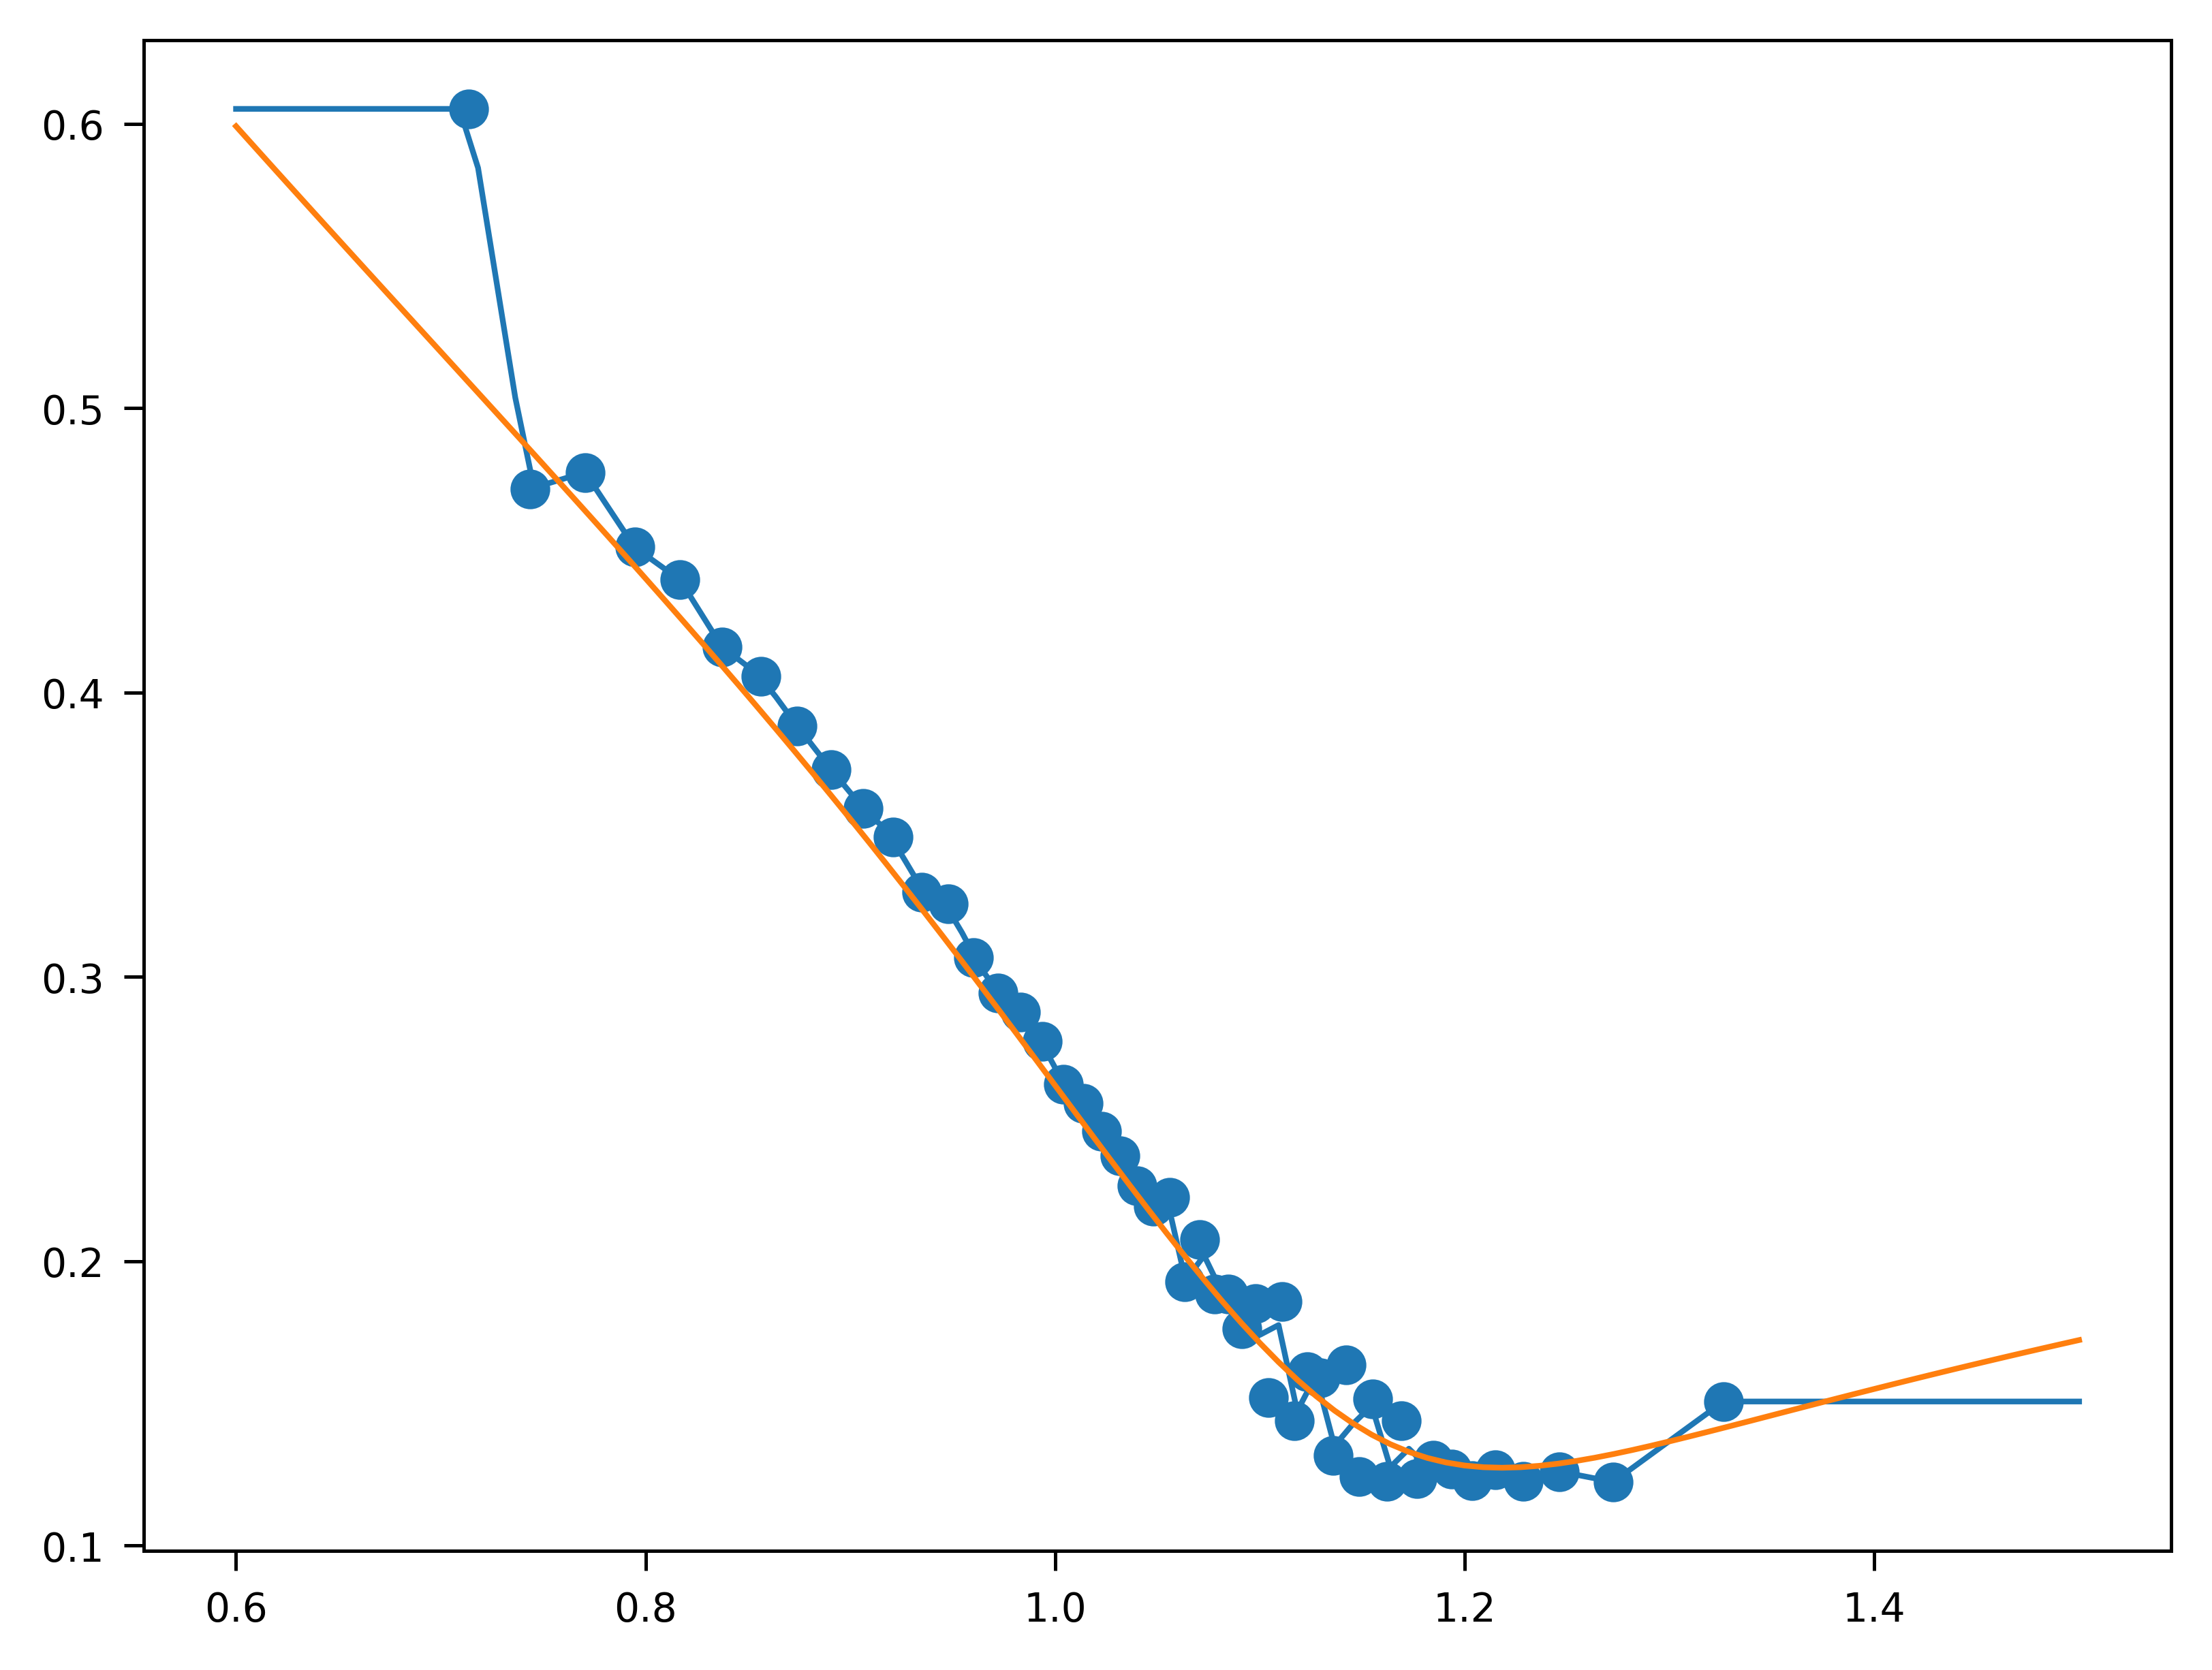

In [8]:
i=-1
t = maturities[i]
print(t)
#k = np.linspace(strikes[i][0], strikes[i][-1], 100)
k = np.linspace(0.6, 1.5, 100)
plt.plot(k, lv.local_vol(t, k))
plt.scatter(strikes[i], lv.local_vol(t, strikes[i]))
plt.plot(k, heston.local_vol(t, k))